# Parallel Processing of Wine Review Data**

## Objective

Can we recreate this $5$ basic wine type groupings?

<p align="center">
<img src="images/Different-Types-of-Wine-v2.jpg"alt="wine types" width="300"><img>
</p>

## Define Wine Classifications

**Helper functions to classify wines into the $9$ basic styles and $5$ basic types**

In [1]:
from collections import namedtuple
import pandas as pd

WINE_STYLE = namedtuple('WINE_STYLE', ['name', 'varieties'])

# wine varieties by wine style
sparkling = WINE_STYLE('sparkling', ['Cava','Prosecco', 'Crémant','Champagne', 'Spumante', 'Sparkling Blend'])

light_white = WINE_STYLE('light_white',
                         ['Albariño','Aligoté','Assyrtiko','Chablis','Chasselas','Chenin Blanc','Cortese','Friulano','Sauvignon Vert','Garganega','Grenache Blanc','Muscadet','Melon','Picpoul de Pinet','Pinot Blanc','Pinot Grigio','Pinot Gris','Verdejo','Verdicchio','Xarel-lo',]\
                          + ['Erbaluce','Grüner Veltliner','Sancerre','Sauvignon Blanc','Vermentino','Vinho Verde']
                        )
full_white = WINE_STYLE('full_white', ['Chardonnay','Marsanna','Sémillon','Trebbiano','Viognier','White Rioja','Pecorino', 'White Blend'])
aromatic_white = WINE_STYLE('aromatic_white', ['Gewürztraminer','Müller-Thurgau','Moschofilero','Muscat','Muscat Blanc','Moscato','Riesling','Torrontés',])
rose = WINE_STYLE('rose', ['Rosé', 'Rose'])
light_red = WINE_STYLE('light_red', ['Schiava', 'Gamay', 'Pinot Noir','Counoise', 'St. Laurent','Cinsaut','Primitivo','Blaufränkisch','Barolo'])
medium_red = WINE_STYLE('medium_red', ['Grenache','Granacha','Valpolicella Blend','Bobal','Carménère','Carignan','Cabernet Franc','Mencía', 'Sangiovese','Negroamaro','Rhône-style Red Blend', 'Rhône/GSM Blend','Barbera','Merlot','Montepulciano','Zinfandel','Marquette','Chambourcin','Petite Pearl','Red Blend', 'Portuguese Red'])
full_red = WINE_STYLE('full_red', ['Tempranillo','Nebbiolo',"Nero d'Avola",'Aglianico','Malbec','Bordeaux Blend','Cabernet Sauvignon','Syrah','Shiraz','Priorat','Touriga Franca','Pinotage','Petit Verdot','Mourvèdre','Touriga Nacional','Petite Sirah','Sagrantino','Tannat','Bordeaux-style Red Blend'])
dessert = WINE_STYLE('dessert', ['Ice Wine','Late Harvest','Madeira','Malvasia','Sauternes','Sherry','Tokaji','Vin Santo','White Port','Port','Porto','Marsala','Noble Rot','Passito','Freisa'])

all_varieties = pd.Series(sparkling.varieties + light_white.varieties + full_white.varieties + aromatic_white.varieties + rose.varieties + light_red.varieties + medium_red.varieties + full_red.varieties + dessert.varieties)

# assign style
styles = [sparkling, light_white, full_white, aromatic_white, rose, light_red, medium_red, full_red, dessert]
to_style = lambda wine: next(map(lambda style: style.name, filter(lambda style: wine in style.varieties, styles)))
to_type = lambda wine: next(map(lambda style: style.name.split('_')[-1], filter(lambda style: wine in style.varieties, styles)))


**Verify that there are no repeated wines varieties in the styles**

In [2]:
# verify there are no variety duplicated in any of the style varietals
assert all_varieties[all_varieties.duplicated()].count() == 0

**Verify the Type & Style Helpers**

In [3]:
assert to_style('Pinot Noir') == 'light_red'
assert to_type('Pinot Noir') == 'red'
to_style('Pinot Noir'), to_type('Pinot Noir')

('light_red', 'red')

## Load Preprocessed Reviews

Libraries

In [4]:
import numpy as np
import time

from IPython.display import Markdown, display

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

Source: Kaggle [Wine Reviews](https://www.kaggle.com/datasets/zynicide/wine-reviews)

In [5]:
df = pd.read_parquet('files/wine_review.parquet.gzip', columns=['title', 'description', 'preprocessed_description', 'variety', 'country', 'location', 'wine_style', 'type', 'classification'])
df.head()


,title,description,preprocessed_description,variety,country,location,wine_style,type,classification
0,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",aroma include tropical fruit broom brimstone...,White Blend,Italy,Etna,light_white,white,Old World
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",do ripe fruity wine smooth structure firm tann...,Portuguese Red,Portugal,Douro,medium_red,red,Old World
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",rainstorm tart snappy flavor lime flesh rind d...,Pinot Gris,US,Oregon,light_white,white,New World
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",pineapple rind lemon pith orange blossom start...,Riesling,US,Michigan,aromatic_white,white,New World
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",vintner like regular bottling come rough tanni...,Pinot Noir,US,Oregon,light_red,red,New World


## Feature Extraction

### Vectorize

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, HashingVectorizer

vectorizer = TfidfVectorizer(max_features=2**12, stop_words="english")
tf_v = vectorizer.fit_transform(df.preprocessed_description)
tf_v.shape

(100538, 4096)

**Inspect Features**

In [7]:
vectorizer.get_feature_names_out()[:50]

array(['10', '16th', '18th', '1970', '19th', '2010', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021',
       '2022', '2023', '2025', '2030', 'abbreviate', 'abeja', 'ability',
       'able', 'abound', 'abrasive', 'abrupt', 'abruptly', 'absolute',
       'absolutely', 'absorb', 'abundance', 'abundant', 'abv', 'acacia',
       'accent', 'accentuate', 'acceptable', 'accessible',
       'accompaniment', 'accompany', 'accord', 'account', 'achieve',
       'achievement', 'acid', 'acidic', 'acidity', 'acquire', 'acre'],
      dtype=object)

**Drop Number Features**

In [8]:
features = np.array(list(filter(lambda col: col[:1].isalpha(), vectorizer.get_feature_names_out())))
features[:50]

array(['abbreviate', 'abeja', 'ability', 'able', 'abound', 'abrasive',
       'abrupt', 'abruptly', 'absolute', 'absolutely', 'absorb',
       'abundance', 'abundant', 'abv', 'acacia', 'accent', 'accentuate',
       'acceptable', 'accessible', 'accompaniment', 'accompany', 'accord',
       'account', 'achieve', 'achievement', 'acid', 'acidic', 'acidity',
       'acquire', 'acre', 'acrid', 'act', 'action', 'actually', 'add',
       'addition', 'additional', 'adequate', 'admirable', 'admirably',
       'adorn', 'advanced', 'advantage', 'aeration', 'affect',
       'affordable', 'affordably', 'african', 'afternoon', 'aftertaste'],
      dtype='<U15')

### Feature Matrix

In [9]:
X = pd.DataFrame(tf_v.toarray(), columns=vectorizer.get_feature_names_out())[features]
X

,abbreviate,abeja,ability,able,abound,abrasive,abrupt,abruptly,absolute,absolutely,...,zesty,zin,zinfandel,zing,zingy,zip,zippy,zone,zull,île
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Visualize the Extracted Features

See [Visualizing TF-IDF Scores: A Comprehensive Guide to Plotting a Document TF-IDF 2D Graph](https://www.geeksforgeeks.org/visualizing-tf-idf-scores-a-comprehensive-guide-to-plotting-a-document-tf-idf-2d-graph/) for reference.

In [10]:
# start with a subset of the data to see how long the operation will take
n_samples = 5_000
s = X if n_samples is None else X.sample(n_samples, random_state=42)
s.head()

,abbreviate,abeja,ability,able,abound,abrasive,abrupt,abruptly,absolute,absolutely,...,zesty,zin,zinfandel,zing,zingy,zip,zippy,zone,zull,île
10484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Dimension Reduction

Since the TF-IDF vectors have $4,076$ dimensions (unique words), we need to reduce the dimensionality to 2D for visualization. We can use either PCA or t-SNE to project our data into a 2D or 3D space that can be easily plotted

**PCA Dimensional Reduction**

In [11]:
from sklearn.decomposition import PCA

start = time.perf_counter()
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(s.to_numpy())
display(Markdown(f'It took {time.perf_counter()-start:.0f} seconds to process {s.shape[0]:,d} samples with {s.shape[1]:,d} features. It will take {X.shape[0]/s.shape[0]*(time.perf_counter()-start)/60:.0f} minutes to process the entire data set.'))
pca_result[:10]

It took 1 seconds to process 5,000 samples with 4,076 features. It will take 0 minutes to process the entire data set.

array([[ 0.0299848 ,  0.06001923],
       [-0.06991993, -0.01930713],
       [-0.08936112, -0.07016665],
       [ 0.08026277,  0.09894288],
       [-0.04490676,  0.06778021],
       [ 0.04499738, -0.15407014],
       [ 0.15836863,  0.0329155 ],
       [-0.03464203,  0.03556592],
       [-0.03849376, -0.06101244],
       [-0.05555566,  0.03683352]])

**t-SNE Dimensional Reduction**

In [12]:
from sklearn.manifold import TSNE

start = time.perf_counter()
tsne = TSNE(random_state=42, perplexity=10)
tsne_result = tsne.fit_transform(s.to_numpy())
display(Markdown(f'It took {time.perf_counter()-start:.0f} seconds to process {s.shape[0]:,d} samples with {s.shape[1]:,d} features. It will take {X.shape[0]/s.shape[0]*(time.perf_counter()-start)/60:.0f} minutes to process the entire data set.'))
tsne_result[:10]

It took 26 seconds to process 5,000 samples with 4,076 features. It will take 9 minutes to process the entire data set.

array([[  3.5640497 ,  71.15322   ],
       [ -6.5916653 ,  14.605319  ],
       [-61.499596  ,  22.49759   ],
       [  2.6642785 ,  65.52785   ],
       [-53.318558  , -33.024742  ],
       [ 72.28652   ,  23.083101  ],
       [  6.4741416 ,  69.07036   ],
       [-20.979696  ,  -0.31644246],
       [ -8.51839   , -66.45226   ],
       [-12.609375  ,  35.15114   ]], dtype=float32)

**t-SNE with PCA Dimensional Reduction**

Use PCA to pre-reduce the dimensions before fitting with t-SNE.

In [13]:
start = time.perf_counter()
pca_tsne = TSNE(random_state=42, perplexity=10)
pca_tsne_result = pca_tsne.fit_transform(PCA(5, random_state=42).fit_transform(s.to_numpy()))
display(Markdown(f'It took {time.perf_counter()-start:.0f} seconds to process {s.shape[0]:,d} samples with {s.shape[1]:,d} features. It will take {X.shape[0]/s.shape[0]*(time.perf_counter()-start)/60:.0f} minutes to process the entire data set.'))
pca_tsne_result[:10]

It took 15 seconds to process 5,000 samples with 4,076 features. It will take 5 minutes to process the entire data set.

array([[ 13.848982 ,  61.048782 ],
       [-64.09519  , -24.967285 ],
       [-20.3802   , -91.21317  ],
       [ 50.557556 ,  31.567324 ],
       [-43.469883 ,  24.64501  ],
       [ 43.153114 , -45.599567 ],
       [ 67.23107  ,  16.813013 ],
       [ 11.1330805,  46.42114  ],
       [-24.05144  , -30.537678 ],
       [-80.016426 ,  -8.095611 ]], dtype=float32)

#### Visualizing the TF-IDF Vectorization Results

**Plot the Result**

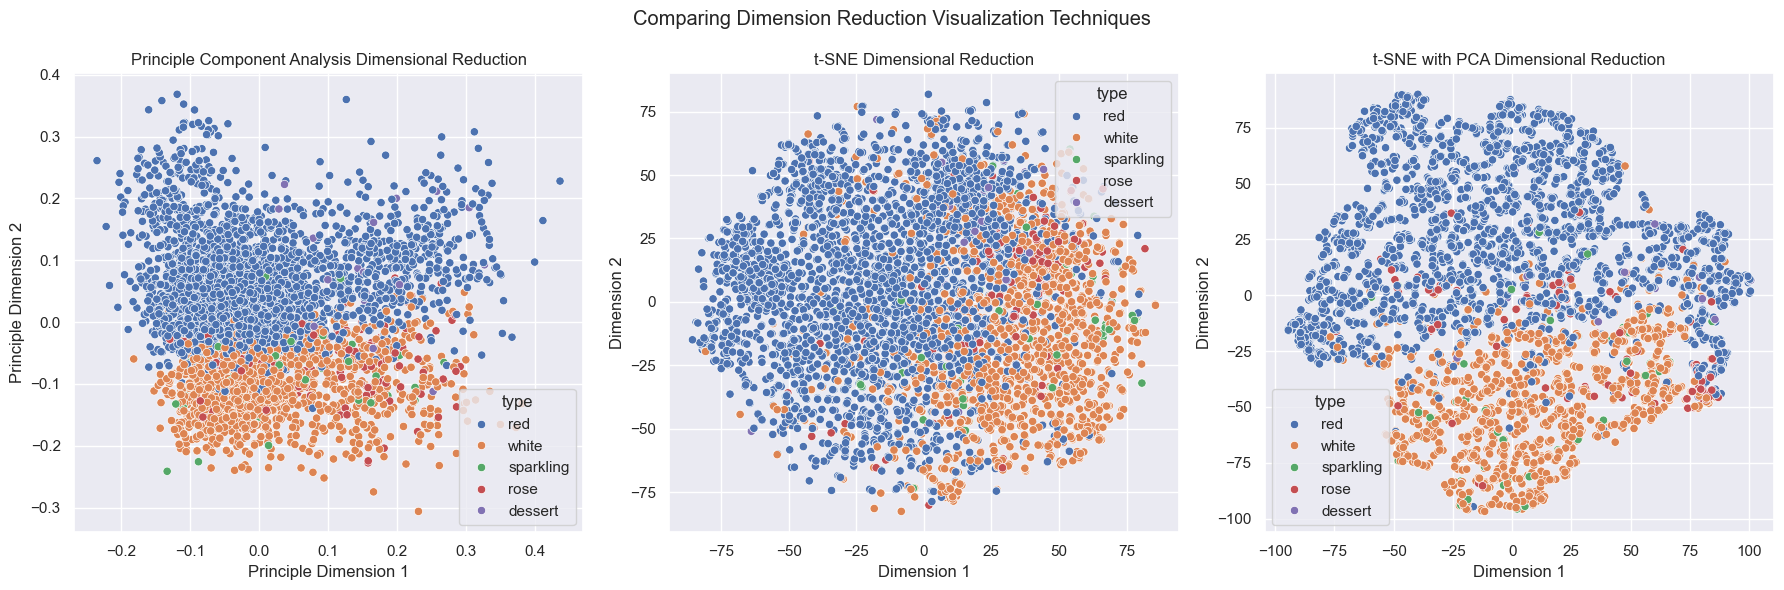

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=df.iloc[s.index].type, ax=ax[0])
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=df.iloc[s.index].type, ax=ax[1])
sns.scatterplot(x=pca_tsne_result[:,0], y=pca_tsne_result[:,1], hue=df.iloc[s.index].type, ax=ax[2])
plt.suptitle('Comparing Dimension Reduction Visualization Techniques')
ax[0].set_xlabel('Principle Dimension 1')
ax[0].set_ylabel('Principle Dimension 2')
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[2].set_xlabel('Dimension 1')
ax[2].set_ylabel('Dimension 2')
ax[0].set_title('Principle Component Analysis Dimensional Reduction')
ax[1].set_title('t-SNE Dimensional Reduction')
ax[2].set_title('t-SNE with PCA Dimensional Reduction')
plt.tight_layout()
plt.show()



**Observation**: The dimensional reduction clearly shows there is some structure to the data

## Cluster Analysis

### KMeans Clustering

see [Clustering documents with TFIDF and KMeans](https://www.kaggle.com/code/jbencina/clustering-documents-with-tfidf-and-kmeans)

**Pick number of clusters for KMeans**

In [15]:
n_clusters = [len(df.classification.unique()),len(df.type.unique()),len(df.wine_style.unique()),20, 35, len(df.variety.unique())]
n_clusters

[2, 5, 9, 20, 35, 50]

**MiniBatchKMeans**

Using MiniBatchKMeans since there are well over 10k samples.

In [16]:
from sklearn.cluster import MiniBatchKMeans

# sum of squared error vs k
models = [MiniBatchKMeans(n_clusters=n, init_size=1024, batch_size=2048, max_iter=100, random_state=42).fit(X) for n in n_clusters]
models

[MiniBatchKMeans(batch_size=2048, init_size=1024, n_clusters=2, random_state=42),
 MiniBatchKMeans(batch_size=2048, init_size=1024, n_clusters=5, random_state=42),
 MiniBatchKMeans(batch_size=2048, init_size=1024, n_clusters=9, random_state=42),
 MiniBatchKMeans(batch_size=2048, init_size=1024, n_clusters=20, random_state=42),
 MiniBatchKMeans(batch_size=2048, init_size=1024, n_clusters=35, random_state=42),
 MiniBatchKMeans(batch_size=2048, init_size=1024, n_clusters=50, random_state=42)]

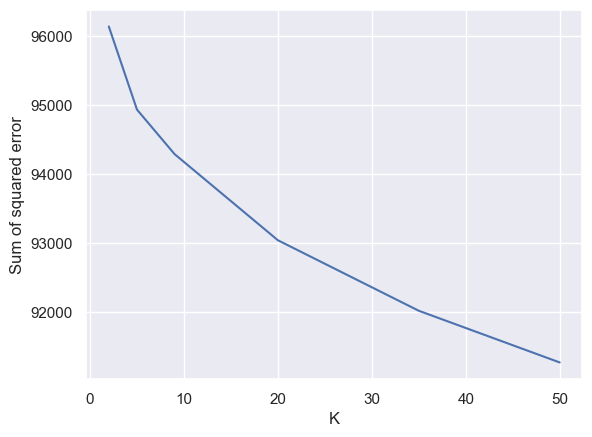

In [17]:
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(n_clusters,[model.inertia_ for model in models])

**Predict the Wine Cluster Based on Review**

In [18]:
df['predicted_classification'] = models[0].predict(X)
df['predicted_type'] = models[1].predict(X)
df['predicted_wine_style'] = models[2].predict(X)
df['predicted_variety'] = models[5].predict(X)

df.head()

,title,description,preprocessed_description,variety,country,location,wine_style,type,classification,predicted_classification,predicted_type,predicted_wine_style,predicted_variety
0,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",aroma include tropical fruit broom brimstone...,White Blend,Italy,Etna,light_white,white,Old World,0,1,0,36
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",do ripe fruity wine smooth structure firm tann...,Portuguese Red,Portugal,Douro,medium_red,red,Old World,1,3,6,20
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",rainstorm tart snappy flavor lime flesh rind d...,Pinot Gris,US,Oregon,light_white,white,New World,1,1,1,33
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",pineapple rind lemon pith orange blossom start...,Riesling,US,Michigan,aromatic_white,white,New World,0,1,1,17
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",vintner like regular bottling come rough tanni...,Pinot Noir,US,Oregon,light_red,red,New World,0,4,8,47


**Visualize Clusters**

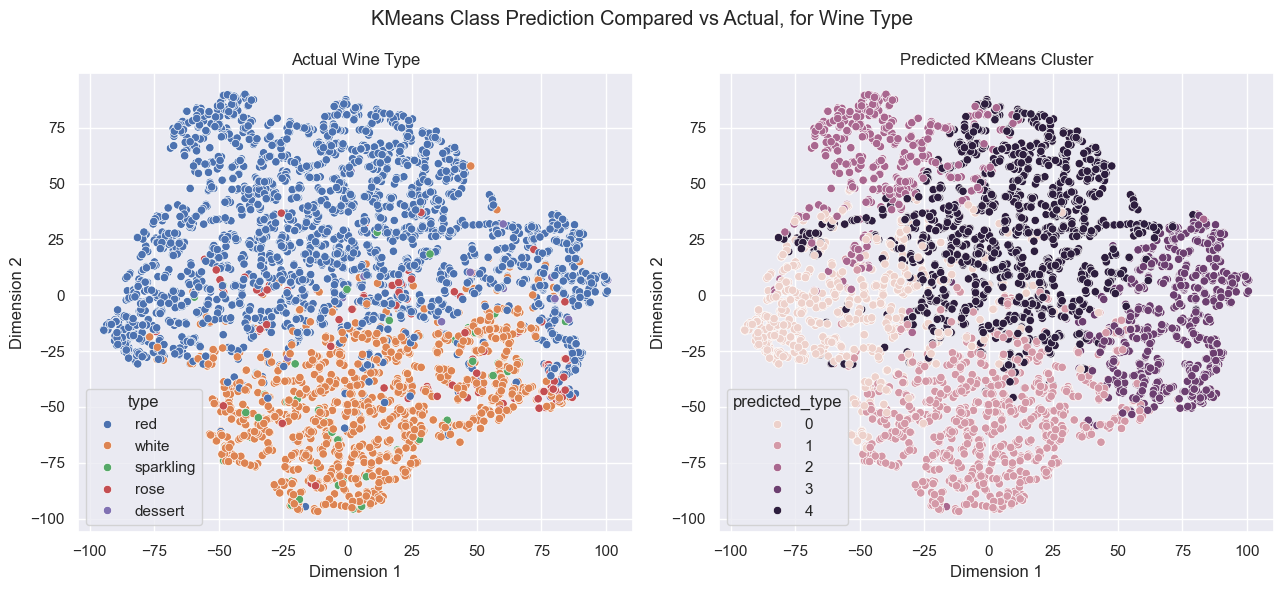

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(13,6))
sns.scatterplot(x=pca_tsne_result[:,0], y=pca_tsne_result[:,1], hue=df.iloc[s.index].type, ax=ax[0])
sns.scatterplot(x=pca_tsne_result[:,0], y=pca_tsne_result[:,1], hue=df.iloc[s.index].predicted_type, ax=ax[1])
plt.suptitle('KMeans Class Prediction Compared vs Actual, for Wine Type')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[0].set_title('Actual Wine Type')
ax[1].set_title('Predicted KMeans Cluster')
plt.tight_layout()
plt.show()

### Agglomerative Clustering

 - [Mastering Text Clustering with Python: A Comprehensive Guide](https://medium.com/@mehdirt/mastering-text-clustering-with-python-a-comprehensive-guide-f8617f53c327) Intro to agglomerative clustering
 - [Cosine Similarity and Hierarchical Clustering](https://rafamarino.com/posts/tfidf/#similarity-score--cosine-similarity)
 - [Mastering Hierarchical Clustering : From Basic to Advanced](https://medium.com/@sachinsoni600517/mastering-hierarchical-clustering-from-basic-to-advanced-5e770260bf93)
 - [Plot Hierarchical Clustering Dendrogram](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html)

In [23]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [52]:
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Hierarchical Clustering
# agglo = AgglomerativeClustering(n_clusters=None, metric='cosine', distance_threshold=0, linkage='average', compute_distances=True).fit(PCA(50, random_state=42).fit_transform(s))
agglo = AgglomerativeClustering(n_clusters=None,distance_threshold=0).fit(PCA(5, random_state=42).fit_transform(s))
agglo

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

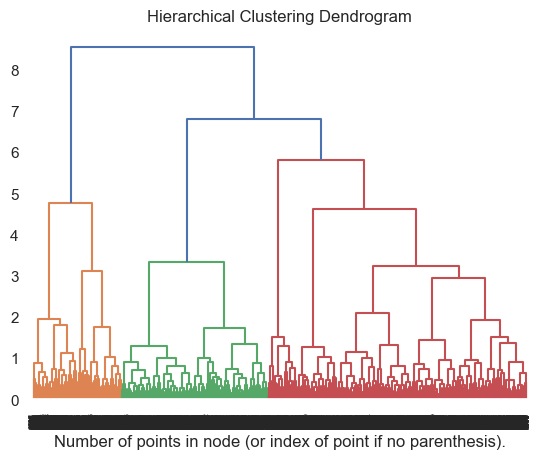

In [53]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agglo, truncate_mode="level")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Further Work

- Evaluate [silhouette](https://medium.com/@hazallgultekin/what-is-silhouette-score-f428fb39bf9a) scores for clusters.